In [1]:
import os
import pandas          as pd
import numpy           as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm.notebook     import tqdm
from scipy.stats       import spearmanr, kendalltau
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns

# options for association models
def pearson_corr(df):
    nan = np.isnan(df['value']) # drop any NaNs
    r, p = pearsonr(df['scaling'][~nan], df['value'][~nan])
    return [r, p]

def spearmanr_corr(df):
    r, p = spearmanr(df['scaling'], df['value'], nan_policy='omit')
    return [r, p]

def kendalltau_corr(df):
    r, p = kendalltau(df['scaling'], df['value'], nan_policy='omit')
    return [r, p]

def linear_model(df):
    # OLS model including specimen as additional factor
    X = sm.add_constant(pd.get_dummies(df['specimen_id'], drop_first=True))
    X['scaling'] = df['scaling']

    mdl = sm.OLS(df['value'], X, missing='drop')
    mdf = mdl.fit()

    return [mdf.params['scaling'], mdf.pvalues['scaling']] 

# run models over all 
def run_models(dataframe, scaling_dict, model='kendalltau'):

    df = dataframe.copy()
    
    # add scaling for each region in df
    df['scaling'] = df['cortical_region'].map(scaling_dict)

    # melt to long format
    long_df = df.melt(id_vars=['specimen_id', 'timepoint', 'tissue', 'cortical_region','scaling']).groupby(['tissue', 'gene'])

    # run models
    if model not in ['pearson', 'spearman', 'kendalltau', 'ols']:
        print('model must be one of: pearson, spearman, kendalltau, ols')
        return None
    if model == 'kendalltau':
        results = pd.DataFrame(long_df.apply(kendalltau_corr)).reset_index()
    if model == 'pearson':
        results = pd.DataFrame(long_df.apply(pearson_corr)).reset_index()
    if model == 'ols':
    # include specimen as a factor (yields ~equivalent pvalues as above) (and takes longer)
        results = pd.DataFrame(long_df.apply(linear_model)).reset_index()
    if model == 'spearman':
        results = pd.DataFrame(long_df.apply(spearmanr_corr)).reset_index()

    
    return results


# dictionaries ###############################################################################3
# tissue zone names
tissue_dict = {'cortical_plate':'0.cortical_plate',
               'subplate': '1.subplate',
               'intermediate': '2.intermediate',
               'subventricular': '3.subventricular',
               'ventricular': '4.ventricular'}
# specimen ages
specimen_age_dict = {'H376.IIIA.02':15, 'H376.IIIB.02':16, 'H376.IV.02':21, 'H376.IV.03':21}

# specimen timepoints
specimen_timepoint_dict = {'H376.IIIA.02':'early', 'H376.IIIB.02':'early', 'H376.IV.02':'mid', 'H376.IV.03':'mid'}

# genes
geneset =  'ZRT'


# SCALING MODEL ###############################################################################
scaling_model = 'OLS'

# OTHER OPTIONS ################################################################################
correlation_model = 'kendalltau'
p_values = 'p'  
alpha = 0.01  # FDR alpha

tissue_palette = ['#7AE582','#21D375',  '#25A18E', '#00A5CF', '#004E64']

# locations ####################################################################################
# location of preprocessed microarray data
microarray_data_path = 'MicroarrayData/'

# location to save outputs
output_dir = 'OUTPUTS/'
results_dir = 'RESULTS/'


### Patterns of gene expression are associated with areal scaling in thrid trimester
To test this hypothesis, we compare gene expression in tissue samples from up to 27 cortical regions across 5 different tissue zones in regions that increase in area at a greater (HYPERallometric) or lesser (HYPOallometric) rate than the cortex as a whole between 21 and 38 weeks gestation.  

In [2]:
# load microarray data
# LOAD DATA ###################################################################################################
microarray_data = pd.read_csv('{:}/final_data.csv'.format(microarray_data_path))
microarray_data['tissue'] = microarray_data['tissue'].map(tissue_dict)





# ORGANISE MICROARRAY DATA ##############################################################################################
# pivot from long format to gene x (specimen, region, tissue) matrix
microarray_data_by_gene = microarray_data.pivot_table(values='expression', index=['gene'] , columns=['cortical_region', 'tissue', 'specimen_id']).T
microarray_data_by_gene = microarray_data_by_gene.reset_index()

# add timepoint information 
microarray_data_by_gene['timepoint'] = microarray_data_by_gene['specimen_id'].map(specimen_timepoint_dict)





# LOAD ZRT GENES ###########################################################################################
gene_list = np.loadtxt('{:}/all-{:}-genes.txt'.format(results_dir, geneset), dtype=str)






# ORGANISE GENESET DATA #######################################################################################
# select geneset columns from microarray df
gene_list_df = microarray_data_by_gene[microarray_data_by_gene.columns[microarray_data_by_gene.columns.isin(gene_list)]]

# add tissue sample metadata back in
gene_list_df = pd.concat((microarray_data_by_gene[['cortical_region', 'tissue', 'specimen_id', 'timepoint']], gene_list_df), axis=1)

# separate early and mid timepoint data
early_gene_list_df = gene_list_df[gene_list_df['timepoint']=='early'].reset_index(drop=True)
mid_gene_list_df = gene_list_df[gene_list_df['timepoint']=='mid'].reset_index(drop=True)

# standardise expression for each region within tissue and specimen (i.e.: for each brain, within each tissue, expression is mean=0 and std=1)
for df in [early_gene_list_df, mid_gene_list_df]:
    for column in df.iloc[:,4:]:
        df[column] = df.groupby(['tissue', 'specimen_id'])[column].transform(lambda x: (x - x.mean())/x.std())

# make sure it worked as expected 
assert np.allclose(1, mid_gene_list_df[(mid_gene_list_df['tissue']==np.random.choice(list(tissue_dict.values()))) & 
                                       (mid_gene_list_df['specimen_id']==np.random.choice(['H376.IV.03', 'H376.IV.02']))][np.random.choice(gene_list, size=1)].std())


For each gene in each tissue zone, we correlate expression (normalised within specimen and tissue) with median areal scaling within each region.

In [3]:
# CORRELATIONS WITH AREAL SCALING ################################################################################
# load areal scaling data
scaling_roi = '{:}/cortical-corr-area-parcellated-scaling-{:}.csv'.format(results_dir, scaling_model)
scaling = pd.read_csv(scaling_roi)
scaling_dict = dict(zip(scaling['name'], scaling['scaling_median']))

# fit models of areal scaling to each gene
# don;t run again if the results file already exists
if not os.path.isfile('{:}/{:}-genes-areal-scaling-{:}-{:}.csv'.format(results_dir, geneset, scaling_model, correlation_model)):

    all_results = []
    for t, df in zip(['early', 'mid'], [early_gene_list_df, mid_gene_list_df]):
        # gene models
        results = run_models(df, scaling_dict, model=correlation_model)
        # format columns
        results[['r','p']] =  results[0].to_list()
        results[['timepoint']] = t
        results.drop(0, axis=1, inplace=True)

        all_results.append(results)

    # collate into single df
    all_results = pd.concat(all_results)
    all_results.to_csv('{:}/{:}-genes-areal-scaling-{:}-{:}.csv'.format(results_dir, geneset, scaling_model, correlation_model))
   
    # perform FDR correction within tissue and timepoints
    all_results[['fdr']] = all_results.groupby(['tissue', 'timepoint'])[p_values].transform(lambda x: (fdrcorrection(x,  alpha=alpha))[0])
    all_results[['fdrp']] = all_results.groupby(['tissue', 'timepoint'])[p_values].transform(lambda x: (fdrcorrection(x, alpha=alpha))[1])

    # save out
    print('see {:}/{:}-genes-areal-scaling-{:}-{:}.csv'.format(results_dir, geneset, scaling_model, correlation_model))
    all_results.to_csv('{:}/{:}-genes-areal-scaling-{:}-{:}.csv'.format(results_dir, geneset, scaling_model, correlation_model), index=None)


In [4]:
all_results = pd.read_csv('{:}/{:}-genes-areal-scaling-{:}-{:}.csv'.format(results_dir, geneset, scaling_model, correlation_model))

# Select significant genes at fdr < 0.01
all_results['scaling_genes'] = (all_results['fdrp']<alpha) 

# positive and negative associations
all_results['positive'] = all_results['r']>0
all_results['negative'] = all_results['r']<0

# just scaling genes
all_scaling = all_results[all_results['scaling_genes']]

print('{:} significant associations detected'.format(np.sum(all_results['scaling_genes'])))
print('in total: {:} significant scaling genes'.format(len(np.unique(all_scaling['gene']))))
# update results
all_results.to_csv('{:}/{:}-genes-areal-scaling-{:}-{:}.csv'.format(results_dir, geneset, scaling_model, correlation_model), index=None)

# add to gene identities
gene_identities = pd.read_csv('{:}/ZRT-gene-identities.csv'.format(results_dir))

is_scaling = []
for g in gene_identities['gene']:
    if g in all_scaling['gene'].to_list():
        is_scaling.append(1)
    else:
        is_scaling.append(0)
    
gene_identities['is_scaling'] = is_scaling
gene_identities.to_csv('{:}/ZRT-gene-identities.csv'.format(results_dir), index=None)

542 significant associations detected
in total: 433 significant scaling genes


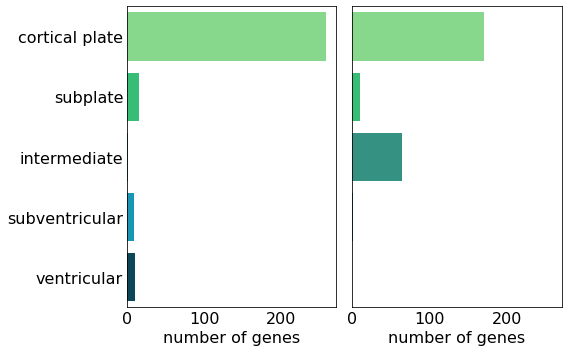

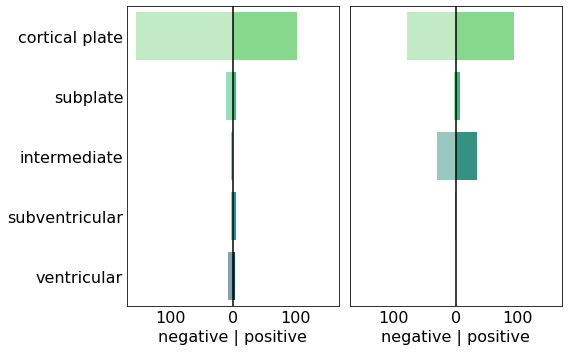

In [5]:
# PLOT NUMBER OF SCALING GENES IN EACH TISSUE TYPE ####################################################33
# how many significant genes in each tissue at each timepoint
count_df = all_scaling.groupby(by=['tissue', 'timepoint']).count().reset_index()
count_df_early = count_df[count_df['timepoint']=='early']
count_df_mid = count_df[count_df['timepoint']=='mid']
# add a dummy row for empty ventricular row in mid timepoint
count_df_mid = count_df_mid.append(pd.Series(['4.ventricular', 'mid'] + [0 for i in np.arange(len(count_df_mid.columns)-2)], index=count_df_mid.columns), ignore_index=True)

# count number of positively adn negatively correlated genes
sum_df = all_scaling.groupby(by=['tissue', 'timepoint']).sum().reset_index()
sum_df['negative'] = -sum_df['negative']
sum_df_early = sum_df[sum_df['timepoint']=='early']
sum_df_mid = sum_df[sum_df['timepoint']=='mid']
# add a dummy row for empty ventricular row
sum_df_mid = sum_df_mid.append(pd.Series(['4.ventricular', 'mid'] + [0 for i in np.arange(len(sum_df_mid.columns)-2)], index=sum_df_mid.columns), ignore_index=True)


# PLOTS
fig, ax = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)
sns.barplot(x='gene', y='tissue', data=count_df_early, ax=ax[0], palette=tissue_palette)
sns.barplot(x='gene', y='tissue', data=count_df_mid, ax=ax[1], palette=tissue_palette)

for a in ax:
    a.tick_params('both', labelsize=16, length=0)
    a.set_ylabel('')
    a.set_xlabel('number of genes', fontsize=16)
ax[0].set_yticklabels(['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular'])
plt.tight_layout()
plt.savefig('{:}/scaling-gene-counts-by-tissue-{:}.png'.format(results_dir, scaling_model), dpi=300, transparent=False, facecolor='white')


fig, ax = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)
sns.barplot(x='positive', y='tissue', data=sum_df_early, ax=ax[0], palette=tissue_palette)
sns.barplot(x='negative', y='tissue', data=sum_df_early, ax=ax[0], alpha=0.5, palette=tissue_palette)
sns.barplot(x='positive', y='tissue', data=sum_df_mid, ax=ax[1], palette=tissue_palette)
sns.barplot(x='negative', y='tissue', data=sum_df_mid, ax=ax[1], alpha=0.5, palette=tissue_palette)
for a in ax:
    a.axvline(0, c='black')
    a.tick_params('both', labelsize=16, length=0)
    a.set_ylabel('')
    a.set_xlabel('negative | positive', fontsize=16)
    a.set_xticks((-100,0,100), labels=[100,0,100])
    a.set_xlim(-170,170)
ax[0].set_yticklabels(['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular'])
plt.tight_layout()
plt.savefig('{:}/scaling-gene-counts-by-tissue-negative-vs-positive-{:}.png'.format(results_dir, scaling_model), dpi=300, transparent=False, facecolor='white')

In [6]:
# re-run scaling analysis after removing allo or peri-allocortical regions 
drop_zones = ['entorhinal',
              'hippocampus',
              'paleocortex',
              'retrosplenial']
if 'r-reduced' not in all_results.columns:


    reduced_early_gene_list_df = early_gene_list_df[~early_gene_list_df['cortical_region'].isin(drop_zones)]
    reduced_mid_gene_list_df = mid_gene_list_df[~mid_gene_list_df['cortical_region'].isin(drop_zones)]

    all_reduced_results = []
    for t, df in zip(['early', 'mid'], [reduced_early_gene_list_df, reduced_mid_gene_list_df]):
        # gene models
        results = run_models(df, scaling_dict, model=correlation_model)
        # format columns
        results[['r','p']] =  results[0].to_list()
        results[['timepoint']] = t
        results.drop(0, axis=1, inplace=True)

        all_reduced_results.append(results)

    # collate into single df
    all_reduced_results = pd.concat(all_reduced_results)
    all_reduced_results[['fdr']] = all_reduced_results.groupby(['tissue', 'timepoint'])[p_values].transform(lambda x: (fdrcorrection(x,  alpha=0.01))[0])
    all_reduced_results[['fdrp']] = all_reduced_results.groupby(['tissue', 'timepoint'])[p_values].transform(lambda x: (fdrcorrection(x, alpha=0.01))[1])

    # add to all_results
    all_results[['r-reduced']] = all_reduced_results[['r']].values
    all_results[['fdrp-reduced']] = all_reduced_results[['fdrp']].values
    all_results[['fdr-reduced']] = all_reduced_results[['fdr']].values
    all_results[['scaling-reduced']] = all_results['fdrp-reduced']<alpha
    all_results.to_csv('{:}/{:}-genes-areal-scaling-{:}-{:}.csv'.format(results_dir, geneset, scaling_model, correlation_model), index=None)


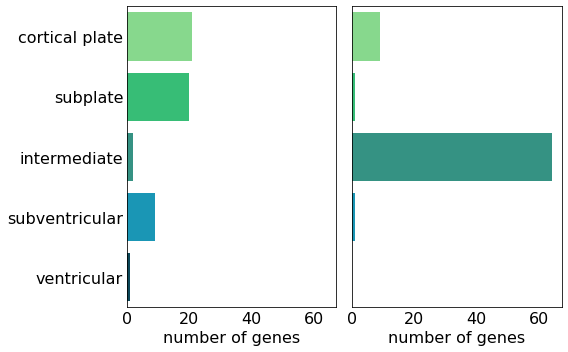

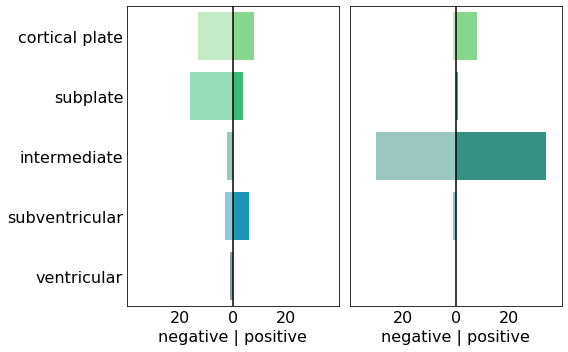

In [7]:
# positive and negative associations
all_results['positive-reduced'] = all_results['r-reduced']>0
all_results['negative-reduced'] = all_results['r-reduced']<0

# just scaling genes
all_reduced_scaling = all_results[all_results['scaling-reduced']]

# how many significant genes in each tissue at each timepoint
reduced_count_df = all_reduced_scaling.groupby(by=['tissue', 'timepoint']).count().reset_index()
count_df_early = reduced_count_df[reduced_count_df['timepoint']=='early']
count_df_mid = reduced_count_df[reduced_count_df['timepoint']=='mid']
# add a dummy row for empty ventricular row in mid timepoint

count_df_mid = count_df_mid.append(pd.Series(['4.ventricular', 'mid'] + [0 for i in np.arange(len(count_df_mid.columns)-2)], index=count_df_mid.columns), ignore_index=True)

# count number of positive and negative
reduced_sum_df = all_reduced_scaling.groupby(by=['tissue', 'timepoint']).sum().reset_index()
reduced_sum_df['negative-reduced'] = -reduced_sum_df['negative-reduced']
sum_df_early = reduced_sum_df[reduced_sum_df['timepoint']=='early']
sum_df_mid = reduced_sum_df[reduced_sum_df['timepoint']=='mid']
# add a dummy row for empty ventricular row
sum_df_mid = sum_df_mid.append(pd.Series(['4.ventricular', 'mid'] + [0 for i in np.arange(len(sum_df_mid.columns)-2)], index=sum_df_mid.columns), ignore_index=True)

# PLOTS
fig, ax = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)
sns.barplot(x='gene', y='tissue', data=count_df_early, ax=ax[0], palette=tissue_palette)
sns.barplot(x='gene', y='tissue', data=count_df_mid, ax=ax[1], palette=tissue_palette)

for a in ax:
    a.tick_params('both', labelsize=16, length=0)
    a.set_ylabel('')
    a.set_xlabel('number of genes', fontsize=16)
ax[0].set_yticklabels(['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular'])
plt.tight_layout()
plt.savefig('{:}/scaling-gene-counts-by-tissue-{:}-reduced.png'.format(results_dir, scaling_model), dpi=300, transparent=False, facecolor='white')

fig, ax = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)
sns.barplot(x='positive-reduced', y='tissue', data=sum_df_early, ax=ax[0], palette=tissue_palette)
sns.barplot(x='negative-reduced', y='tissue', data=sum_df_early, ax=ax[0], alpha=0.5, palette=tissue_palette)
sns.barplot(x='positive-reduced', y='tissue', data=sum_df_mid, ax=ax[1], palette=tissue_palette)
sns.barplot(x='negative-reduced', y='tissue', data=sum_df_mid, ax=ax[1], alpha=0.5, palette=tissue_palette)
for a in ax:
    a.axvline(0, c='black')
    a.tick_params('both', labelsize=16, length=0)
    a.set_ylabel('')
    a.set_xlabel('negative | positive', fontsize=16)
    a.set_xticks((-20,0,20), labels=[20,0,20])
    a.set_xlim(-40,40)
ax[0].set_yticklabels(['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular'])
plt.tight_layout()
plt.savefig('{:}/scaling-gene-counts-by-tissue-negative-vs-positive-{:}-reduced.png'.format(results_dir, scaling_model), dpi=300, transparent=False, facecolor='white')

In [8]:
removed_genes = list(set(all_scaling['gene']) - set(all_reduced_scaling['gene']))
kept_genes = list(set(all_scaling['gene']) & set(all_reduced_scaling['gene']))

# add to gene identities
gene_identities = pd.read_csv('{:}/ZRT-gene-identities.csv'.format(results_dir))

is_scaling_reduced = []
for g in gene_identities['gene']:
    if g in all_reduced_scaling['gene'].to_list():
        is_scaling_reduced.append(1)
    else:
        is_scaling_reduced.append(0)

gene_identities['is_scaling_reduced'] = is_scaling_reduced

        
is_removed = []
for g in gene_identities['gene']:
    if g in removed_genes:
        is_removed.append(1)
    else:
        is_removed.append(0)
    
gene_identities['is_removed'] = is_removed
gene_identities.to_csv('{:}/ZRT-gene-identities.csv'.format(results_dir), index=None)